<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep%20Learnig%20from%20Scratch%202/improvedCBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !git clone https://github.com/ExcelsiorCJH/DLFromScratch2.git

In [3]:
cd /content/drive/MyDrive/밑시딥2/DLFromScratch2

/content/drive/MyDrive/밑시딥2/DLFromScratch2


# simpleCBOW 모델의 문제점

1. 원핫 표현의 벡터 크기 -> 상당한 메모리 차지 -> Embedding 계층으로 해결

2. 은닉층 이후의 계산 -> 어휘량이 증가할 수록 은닉층의 뉴런과 가중치 행렬(W_out)의 계산 & Softmax 계층에서 계산량 증가 -> Negative Sampling 도입 

In [4]:
# embedding class -> 행렬에서 특정 행 추출
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
  
  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out
    
  def backward(self, dout):
    dw, = self.grads
    dw[...] = 0 # [...] -> Ellipsis: 지정하지 않은 array의 나머지 전체를 의미한다

    # dw[self.idx] = dout # 이런 식으로 할당하는 방식 -> idx가 중복될 경우 덮어쓰게 된다는 문제 발생
    for i, word_id in enumerate(self.idx):
      dw[word_id] += dout[i]
      
    return None

In [5]:
# embedding dot
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None

  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis=1)

    self.cache = (h, target_W)
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)
    
    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

In [6]:
# negative sampling
#  multi-class classification에서 binary classification
#  부정적 예를 몇 개, 즉 sampling 하는 것 -> 5개라든지 10개
from Chap04_Word2Vec_Improved.negative_sampling_layer import UnigramSampler

class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5):
    self.sample_size = sample_size 
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads
          
  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)
    
    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype=np.int32)
    loss = self.loss_layers[0].forward(score, correct_label)
    
    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype=np.int32)
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label)
        
    return loss
  
  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)
    
    return dh

# CBOW model

In [11]:
import numpy as np
from common.layers import Embedding
from Chap04_Word2Vec_Improved.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        self.word_vecs1 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

# CBOW 모델 학습

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 7[s] | 손실 3.79
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 11[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 12[s] | 손실 3.27
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 15[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 16[s] | 손실 3.03
| 에폭 1 |  반복 281 / 9295 | 시간 17[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 19[s] | 손실 2.89
| 에폭 1 |  반복 321 / 9295 | 시간 20[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 21[s] | 손실 2.84
| 에폭 1 |  반복 361 / 9295 | 시간 22[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 24[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 25[s] | 손실 2.76
| 에폭 1 |  반복 421 / 9295 | 시간 26[s] | 손실 2.74
| 에폭 1 |  반복 441 / 9295 

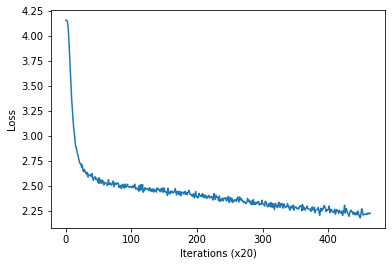

In [12]:
from common import config
# GPU에서 실행하고 싶다면, 아래 주석 해제하셈
config.GPU = False

import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 1 # 너무 오래걸리길레 우선 10번에서 1번으로 줄임. loss에는 큰 차이가 없어 보이길래

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

In [13]:
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.978515625
 i: 0.96484375
 'm: 0.96142578125
 else: 0.96142578125
 not: 0.95556640625

[query] year
 month: 0.912109375
 week: 0.87841796875
 earlier: 0.875
 quarter: 0.8369140625
 second: 0.82861328125

[query] car
 carrier: 0.9638671875
 farmer: 0.9599609375
 window: 0.9580078125
 eye: 0.95751953125
 institution: 0.95654296875

[query] toyota
 maintenance: 0.955078125
 state-controlled: 0.9541015625
 hardware: 0.95166015625
 electrical: 0.95068359375
 kodak: 0.94921875
